<a href="https://colab.research.google.com/github/akre96/BUS_tumor_classification/blob/master/GAN/DCGAN_Ultrasound.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [0]:
import os
import matplotlib.pyplot as plt
import fnmatch
import cv2 as cv
import numpy as np
import importlib

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
pwd

'/content/drive/My Drive/BREAST_ultrasound'

In [10]:
cd "drive/My Drive/BREAST_ultrasound/"

[Errno 2] No such file or directory: 'drive/My Drive/BREAST_ultrasound/'
/content/drive/My Drive/BREAST_ultrasound


In [0]:
from data_loader import readAll, getgoodfiles, get_stratified_good_files

In [0]:
normal_files, benign_files, malignant_files = get_stratified_good_files()

"""Define root paths, relative paths for busi data classes"""
rootDir = "./"
busiDir = os.path.join(rootDir, "data/dataset_busi")
benignDir = os.path.join(rootDir, busiDir,"benign")
malDir = os.path.join(rootDir, busiDir,"malignant")
normDir = os.path.join(rootDir, busiDir ,"normal")

orig_benign = readAll(benignDir, benign_files, process = False)
benign = readAll(benignDir, benign_files, out_size= (224,224))
malignant = readAll(malDir, malignant_files, out_size=(224, 224))
normal = readAll(normDir, normal_files, out_size = (224, 224))

In [13]:
"""checking preprocess sizes"""
shapes = []
for i in normal:
    tmp_shape = np.array(i).shape
    shapes.append(tmp_shape)
shapes = set(shapes)
print("shapes before preprocessing: ", shapes)

shapes before preprocessing:  {(224, 224)}


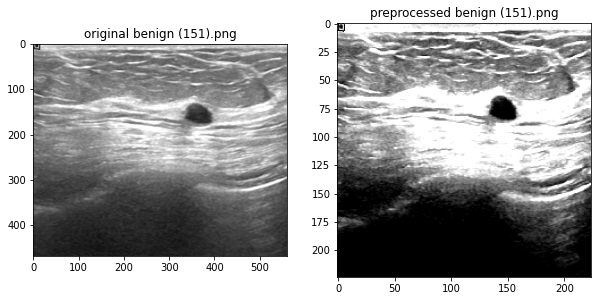

In [14]:
"""Show original and after preprocess"""
i = 50
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 5))
axs[0].set_title("original "+ benign_files[i])
axs[0].imshow(orig_benign[i], cmap = 'gray')
axs[1].set_title("preprocessed "+ benign_files[i])
axs[1].imshow(benign[i], cmap = 'gray')

In [0]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.2.0


In [0]:
def splitData(full_data, percent = .20):
    np.random.shuffle(full_data)
    bound = int(np.floor(len(full_data)*.2))*-1
    return full_data[:bound], full_data[bound:]

In [0]:
"""Split the Data"""
fullset = np.concatenate((benign, malignant, normal))
X_train, X_valid = splitData(fullset, .2)
X_train, X_valid = np.array(X_train).astype(np.float32), np.array(X_valid)
len(X_train), len(X_valid)

# Denoising AutoEncoder

In [0]:
from visualizer import show_reconstructions

In [0]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

"""splitData takes in a full dataset and 
   split it between X_train, X_valid after shuffle

In [0]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [0]:
#tf.random.set_seed(42)
#np.random.seed(42)
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[256, 256]),
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(1000, activation="selu"),
    
    keras.layers.Dense(500, activation="selu"),
    keras.layers.Dense(200, activation="selu"),

    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(200, activation="selu"),
    keras.layers.Dense(500, activation="selu"),
    keras.layers.Dense(1000, activation="selu"),
    keras.layers.Dense(256 * 256, activation="sigmoid"),
    keras.layers.Reshape([256, 256])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_encoder.summary()
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])

history = denoising_ae.fit(X_train, X_train, batch_size = 10, epochs=30,validation_data=(X_valid, X_valid))
noise = keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

In [0]:
dropout_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[256, 256]),
    #keras.layers.Dropout(0.5),
    keras.layers.Dense(10000, activation="selu"),
    keras.layers.Dense(5000, activation="selu"),
    keras.layers.Dense(3000, activation="selu"),
    keras.layers.Dense(1000, activation="selu")
    #,
    #keras.layers.Dense(30, activation="selu")
])
dropout_decoder = keras.models.Sequential([
    #keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(3000, activation="selu", input_shape=[1000]),
    keras.layers.Dense(5000, activation="selu"),
    keras.layers.Dense(10000, activation="selu"),
    keras.layers.Dense(256 * 256, activation="sigmoid"),
    keras.layers.Reshape([256, 256])
])
dropout_ae = keras.models.Sequential([dropout_encoder, dropout_decoder])
dropout_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=0.01),
                   metrics=[rounded_accuracy])
history = dropout_ae.fit(X_train, X_train, epochs=100,
                         validation_data=(X_valid, X_valid))

batch x number channels x width x height 

In [0]:
show_reconstructions(dropout_ae, X_valid)
plt.show()
dropout_ae.save("denoising_ae_model.h5")

# Convolutional AE 

In [0]:
"""
    Discriminator's architecture: 
    input   : 128 x 128 x 1 (single channel, 256x256 image) 
    h1      : 64 x 64 x 32 
    h2      : 32  x 32  x 64 
    h3      : 16  x 16  x 128
    h4      : 8 x 8 x 256
"""
#conv_encoder = keras.models.Sequential() 
input_img = keras.layers.Input(shape = (128,128,1))
h1_con_en = keras.layers.Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = "SAME",
                                activation= 'relu')(input_img)
h1_con_en = keras.layers.MaxPool2D(pool_size = 2)(h1_con_en)

""" 
h2_con_en = keras.layers.Conv2D(filters = 64, kernel_size = 5, strides = 1, padding = "SAME",
                                activation= 'relu')(h1_con_en)
h2_con_en = keras.layers.MaxPool2D(pool_size = 2)(h2_con_en)
h3_con_en = keras.layers.Conv2D(filters = 128, kernel_size = 5, strides = 1, padding = "SAME",
                                activation= 'relu')(h2_con_en)
h3_con_en = keras.layers.MaxPool2D(pool_size = 2)(h3_con_en)
h4_con_en = keras.layers.Conv2D(filters = 256, kernel_size = 5, strides = 1, padding = "SAME",
                                activation= 'relu')(h3_con_en)
conv_encoder = keras.layers.MaxPool2D(pool_size = 2)(h4_con_en)
"""

"""
architecture design from latent 
    decoder's architecture: 
    input   : 8 x 8 x 256  (single channel, 256x256 image) 
    h1      : 16  x 16  x 128
    h2      : 32  x 32  x 64 
    h3      : 64 x 64 x 32 
    output      : 128 x 128 x 1 
"""

h1_con_de = keras.layers.Conv2DTranspose(filters = 128, kernel_size = 5, strides = 2, padding = "SAME",
                                activation= 'relu', input_shape = [8, 8, 256], use_biase)(conv_encoder)
h2_con_de = keras.layers.Conv2DTranspose(filters = 64, kernel_size = 5, strides = 2, padding = "SAME",
                                activation= 'relu')(h1_con_de)
h3_con_de = keras.layers.Conv2DTranspose(filters = 32, kernel_size = 5, strides = 2, padding = "SAME",
                                activation= 'relu')(h2_con_de)
conv_decoder = keras.layers.Conv2DTranspose(filters = 1, kernel_size = 5, strides = 2, padding = "SAME",
                                activation= 'relu')(h3_con_de)
#, conv_decoder
conv_ae = keras.models.Model(input_img, conv_decoder)
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(lr=0.0001),
                   metrics=[rounded_accuracy])
conv_ae.summary()
history = conv_ae.fit(X_train_dcgan, X_train_dcgan, epochs=100,
                         validation_data=(X_valid_dcgan, X_valid_dcgan))
#conv_encoder.summary()
#conv_decoder.summary()

In [0]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols*2, n_rows*2))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

# Convolutional GAN Network

In [0]:
import generator_loss 
import discriminator_loss 
import importlib as imp
import time
from IPython import display

In [0]:
""" augment dimension of dataset to  
    (batch_size, width, height, input_channel) 
"""
def aug_channel(img, aug_depth = 1):
    img = np.array(img)
    batch, row, col = img.shape 
    img2 = img.reshape(-1, row, col, aug_depth)
    print("Successful depth augmentation(batch, row, col) -> (batch, row, col, depth) \n \t \t \t    ",
          img.shape, "  ->", img2.shape )
    return img2 


In [0]:
#X_train_dcgan, X_valid_dcgan = splitData(fullset)
#X_train_dcgan, X_valid_dcgan = aug_channel(X_train), aug_channel(X_valid_dcgan)

In [0]:
batch_size = 64
X_train_dcgan, X_valid_dcgan = splitData(fullset)
X_train_dcgan, X_valid_dcgan = aug_channel(X_train), aug_channel(X_valid_dcgan)

dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)
print("\n")
print("Created dataset with batch shape: ", dataset)

validation = tf.data.Dataset.from_tensor_slices(X_valid_dcgan)
validation = validation.shuffle(1000)
validation = validation.batch(batch_size, drop_remainder=True).prefetch(1)

bound =  -116
Successful depth augmentation(batch, row, col) -> (batch, row, col, depth) 
 	 	 	     (464, 224, 224)   -> (464, 224, 224, 1)
Successful depth augmentation(batch, row, col) -> (batch, row, col, depth) 
 	 	 	     (116, 224, 224)   -> (116, 224, 224, 1)


Created dataset with batch shape:  <PrefetchDataset shapes: (64, 224, 224, 1), types: tf.float32>


## Generator Code

In [0]:
codings_size = 100
"""
architecture design from latent -> 256 x 256
<https://arxiv.org/pdf/1712.01636.pdf>
    Generator's architecture: 
    input   : 1 x 100 (latent variable space) 
    h1      : 56 x 56 x 256
    h2      : 56 x 56 x 128
    h3      : 112 x 112 x 64
    output  : 224 x 224 x 1 
"""
generator_use_bias = False 
discriminator_use_bias = False

def build_generator():
  generator = keras.models.Sequential()  

  #56x56x256 (linear)
  generator.add(keras.layers.Dense(56*56*256, use_bias=False, input_shape=(codings_size,)))
  generator.add(keras.layers.BatchNormalization())
  generator.add(keras.layers.LeakyReLU(0.02))
    
  #56x56x256 -> 56x56x128 (because of strides(1,1))
  generator.add(keras.layers.Reshape([56, 56, 256]))
  generator.add(keras.layers.Conv2DTranspose(128, kernel_size=(5,5), strides=(1,1),
                                             padding="SAME", use_bias=generator_use_bias ))
  generator.add(keras.layers.BatchNormalization())
  generator.add(keras.layers.LeakyReLU(.02))

  #56x56x128 -> 112x112x64
  generator.add(keras.layers.Conv2DTranspose(64, kernel_size=(5,5), 
                                             strides=(2,2), padding="SAME",
                                             use_bias=generator_use_bias))
  generator.add(keras.layers.BatchNormalization())
  generator.add(keras.layers.LeakyReLU(.02))

  #112x112x64 -> 224x224x1
  generator.add(keras.layers.Conv2DTranspose(1, kernel_size=(5,5), strides=(2,2),
                                             padding="SAME",activation="tanh"))
  return generator

## Discriminator Codes

In [0]:
"""
    Discriminator's architecture: 
    input   : (224 x 224 x 1) (single channel, 224x224 image) 
    h1      : (112x112x64)
    h2      : (56x56x128)
    h3      : 56x56x128   
    h4      : 124x1
    output      : 1x1
"""
def build_discriminator():
  discriminator = keras.models.Sequential()
  #224x224x1 -> 112x112x64
  discriminator.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[224, 224, 1]))
  discriminator.add(keras.layers.LeakyReLU())
  discriminator.add(keras.layers.Dropout(0.3))
  
  #112x112x64 -> 56x56x128
  discriminator.add(keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  discriminator.add(keras.layers.LeakyReLU())
  discriminator.add(keras.layers.Dropout(0.3))

  #(56x56x128) -> 56x56x128 
  discriminator.add(keras.layers.Flatten())

  # go through another 124 dense layers ()
  # add dropout 
  discriminator.add(keras.layers.Dense(124))
  discriminator.add(keras.layers.Dropout(0.3))

  discriminator.add(keras.layers.Dense(1))
  return discriminator

## Build generator and discriminator

In [0]:
generator = build_generator()
discriminator = build_discriminator()
generator.summary()
discriminator.summary()
gan = keras.models.Sequential([generator, discriminator])
gan.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 802816)            80281600  
_________________________________________________________________
batch_normalization (BatchNo (None, 802816)            3211264   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 802816)            0         
_________________________________________________________________
reshape (Reshape)            (None, 56, 56, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 56, 56, 128)       819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 128)       512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 56, 56, 128)       0

## Use Pretrained weights for DCGAN over 2000 epochs 
Download [weights of GAN model(~1.3Gb)](https://drive.google.com/file/d/1-1Kjnsv-k2zwDTktOBmuRJ-XULj0aYVt/view?usp=sharing)

## Train from scratch

In [0]:
checkpoint_dir = './training_checkpoints_model_embedding224'

In [0]:
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0001)
generator_optimizer = tf.keras.optimizers.Adam(lr=0.00002)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [0]:
def generate_and_save_images(model, epoch, test_input,  
                             generate_path = "./generated_imgs224_3layers/"):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    if not os.path.exists(generate_path):
        os.mkdir(generate_path)
   
    plt.savefig(os.path.join(generate_path,'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()

### Training function 

In [0]:
@tf.function
def train_step(gan, X_batch, training = True, codings_size = 120):
    generator, discriminator = gan.layers
    noise = tf.random.normal(shape=[batch_size, codings_size])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        """phase 1 - training the discriminator """
        generated_images = generator(noise, training = True)            
        D_fake= discriminator(generated_images, training = True)
        D_real= discriminator(X_batch, training = True)
        
        D_loss= discriminator_loss.discriminator_minimax_loss(D_real, D_fake,
                                                              print_loss = False,
                                                              label_smoothing = 0.1)        
        """phase 2 - training the generator"""     
        G_loss = generator_loss.generator_minimax_loss(D_fake, 
                                                       nonsaturating = True,
                                                       print_loss = False,
                                                       label_smoothing = 0.0)
    """ if training, then change the gradients
        otherwise return the loss 
    """
    if training:
        """based on loss function, generates a gradient"""
        gradients_of_discriminator = disc_tape.gradient(D_loss, 
                                                        discriminator.trainable_variables)
        gradients_of_generator = gen_tape.gradient(G_loss, 
                                                   generator.trainable_variables)

        """change the weights by applying gradients"""
        generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                                generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                                    discriminator.trainable_variables))
        return (D_loss, G_loss),(gradients_of_discriminator, gradients_of_generator)
    else:
        return (D_loss, G_loss), None

In [0]:
#train_Dloss_path = "dloss.npy"
#train_Gloss_path = "gloss.npy"
#elapse_time = "elapse.npy"
writer = tf.summary.create_file_writer('./summaries_coding120_size224')
def train_gan(gan, dataset, validation, batch_size, 
              codings_size, begin_epoch = 1, n_epochs=15, save_point= 15):
    train_Dloss_results = []
    train_Gloss_results = []
    #train_Dgrad_results = []
    #train_Ggrad_results = []
    elapse = [] 
    #train_accuracy_results = []
    total_time = time.time()
    
    #generator, discriminator = gan.layers
    #gen_histogram_summary = tf.summary.histogram('gen_histogram_summary', generator.trainable_variables)
    #disc_histogram_summary = tf.summary.histogram('disc_histogram_summary', discriminator.trainable_variables)
    
    generator, discriminator = gan.layers 
    generator_trainable_names = []
    discriminator_trainable_names = []
    for i in generator.trainable_variables:
        generator_trainable_names.append(i.name)
    for i in discriminator.trainable_variables:
        discriminator_trainable_names.append(i.name)
        
    with writer.as_default():
        for epoch in range(begin_epoch, n_epochs):
            """epoch_loss_avg track the losses"""
            epoch_Dloss_avg = tf.keras.metrics.Mean(name = 'd_loss')
            epoch_Gloss_avg = tf.keras.metrics.Mean(name = 'g_loss')
            epoch_lapse = time.time()
            for X_batch in dataset:

                loss, grad = train_step(gan, X_batch, training = True, codings_size= codings_size)
                (D_loss, G_loss)= loss
                (gradients_of_discriminator, gradients_of_generator) = grad             

                """Track progress D_loss, G_loss, Dgrad, Ggrad progress"""
                epoch_Dloss_avg.update_state(D_loss)  
                epoch_Gloss_avg.update_state(G_loss)

                """ try validating steps
                (valid_D_loss, valid_G_loss), _  = train_step(gan, X_batch, training = False, 
                                                             codings_size= codings_size,
                                                             n_epochs = n_epochs, save_point = save_point)
                """
                # Compare predicted label to actual label
                # training=True is needed only if there are layers with different
                # behavior during training versus inference (e.g. Dropout).
                #epoch_accuracy.update_state(y, model(x, training=True))

                # End epoch

            train_Gloss_results.append(epoch_Gloss_avg.result())
            train_Dloss_results.append(epoch_Dloss_avg.result())
            
            #train_accuracy_results.append(epoch_accuracy.result())
            epoch_lapse = time.time() - epoch_lapse
            print("Epoch {}/{} lapsed ..............{} secs".format(epoch + 1, n_epochs, epoch_lapse))             
            print("Epoch {:04d}: Generator Loss: {:.3f}".format(epoch+1, epoch_Gloss_avg.result()))
            print("Epoch {:04d}: Discriminator Loss: {:.3f}".format(epoch+1, epoch_Dloss_avg.result()))
            # Save the model every 15 epochs
            if epoch % save_point == 0:
                checkpoint.save(file_prefix = checkpoint_prefix)
                # Generate after the final epoch
                display.clear_output(wait=True)
                generate_and_save_images(generator,
                                         epoch,
                                         seed)
            #d_loss_file = "loss_log/dloss2.npy"
            #g_loss_file = "loss_log/gloss2.npy"
            #np.save(d_loss_file, np.array(train_Dloss_results))
            #np.save(g_loss_file, np.array(train_Gloss_results))

            """record weights at the end of each epoch"""
            tf.summary.scalar("g_loss", epoch_Gloss_avg.result(), step = epoch)
            tf.summary.scalar("d_loss", epoch_Dloss_avg.result(), step = epoch)
            
            for name, grad in zip(generator_trainable_names,gradients_of_generator):
                
                tf.summary.histogram("g_grad {}".format(name), grad, epoch)
                
            for name, grad in zip(discriminator_trainable_names, gradients_of_discriminator):
                tf.summary.histogram("d_grad {}".format(name),data = grad, step = epoch)
            writer.flush()
        # Generate after the final epoch
        checkpoint.save(file_prefix = checkpoint_prefix)
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 n_epochs,
                                 seed)
    print('done writting the summaries')
    return train_Dloss_results, train_Gloss_results

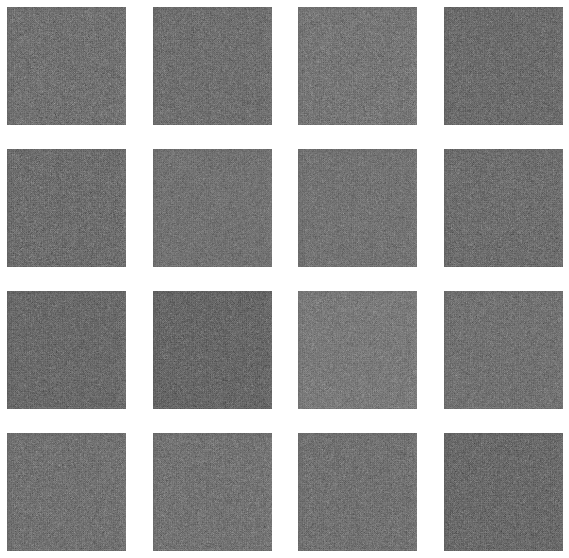

In [0]:
#Check if noises before training 
generator, discriminator = gan.layers
seed = tf.random.normal([num_examples_to_generate, codings_size])
generate_and_save_images(generator, 0, seed)

In [0]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
#display_image(EPOCHS)

### Epoch from [0 - 486]  

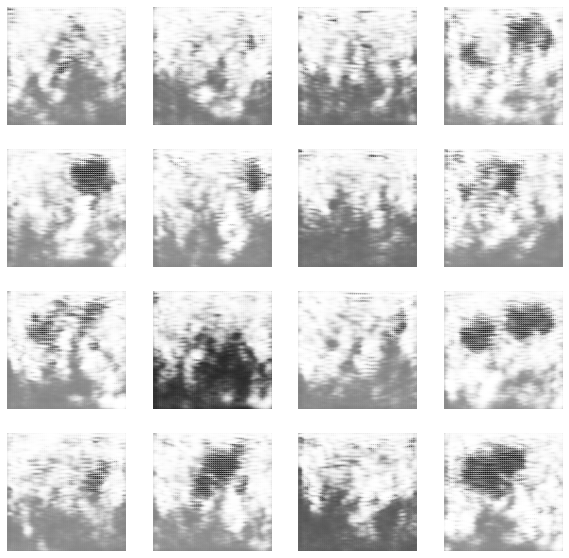

Epoch 482/2000 lapsed ..............1.9595375061035156 secs
Epoch 0482: Generator Loss: 4.286
Epoch 0482: Discriminator Loss: 0.633
Epoch 483/2000 lapsed ..............1.967071294784546 secs
Epoch 0483: Generator Loss: 4.640
Epoch 0483: Discriminator Loss: 0.578
Epoch 484/2000 lapsed ..............1.9429190158843994 secs
Epoch 0484: Generator Loss: 5.631
Epoch 0484: Discriminator Loss: 0.600
Epoch 485/2000 lapsed ..............1.9450428485870361 secs
Epoch 0485: Generator Loss: 5.063
Epoch 0485: Discriminator Loss: 0.645
Epoch 486/2000 lapsed ..............1.9516923427581787 secs
Epoch 0486: Generator Loss: 8.276
Epoch 0486: Discriminator Loss: 0.840


KeyboardInterrupt: ignored

In [0]:
import time
#model 1 results
train_Dloss_results, train_Gloss_results = train_gan(gan, dataset, validation, 
                                                     batch_size, codings_size = codings_size,
                                                     begin_epoch = 0,
                                                     n_epochs=2000, save_point=200)

### Restore Checkpoints

In [0]:
#restore the weights and continue training
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

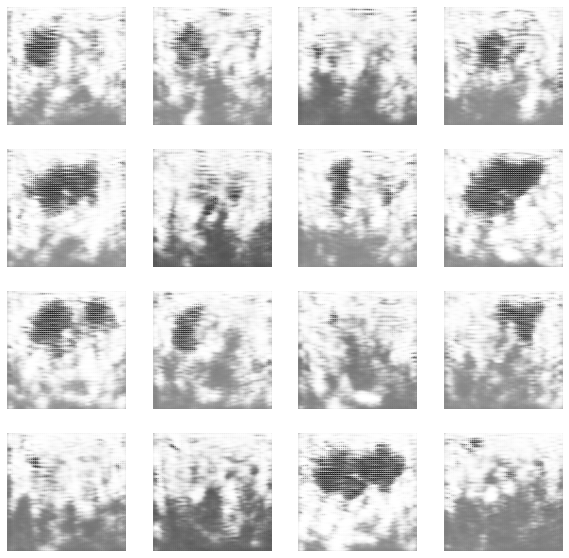

In [0]:
#before anything 
generate_and_save_images(generator, -1, seed)

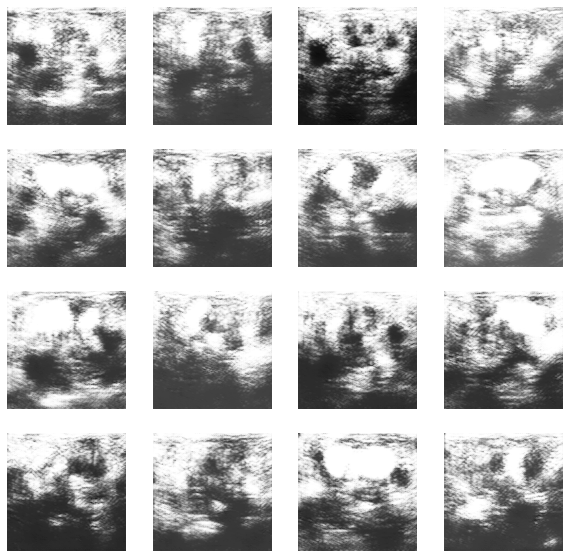

done writting the summaries


In [0]:
import time
#model 1 results
train_Dloss_results, train_Gloss_results = train_gan(gan, dataset, validation, 
                                                     batch_size, codings_size = codings_size,
                                                     begin_epoch = 486,
                                                     n_epochs=2000, save_point=200)

In [0]:
#save the last checkpoint at epoch = 2000
checkpoint.save(file_prefix = checkpoint_prefix)

'./training_checkpoints_model_embedding224/ckpt-32'

#reference
https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb#scrollTo=2M7LmLtGEMQJ&uniqifier=1

# ...........................